In [56]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from datetime import datetime
import matplotlib.pyplot as plt

#from markowitz import MarkowitzOpt


In [57]:


StockList = ['AAPL','IBM','MSFT','GOOG','QCOM']		# Stock ticker names
interest_rate = 0.03/12								# Fixed interest rate
min_return = 0.02									# Minimum desired return

# Read stock prices data
price = pd.read_csv('/StockPrices.csv')
price.index = [datetime.strptime(x,'%Y-%m-%d') for x in price['Date']]
price = price.drop('Date',1)

# Specify number of days to shift
shift = 20
# Compute returns over the time period specified by shift
shift_returns = price/price.shift(shift) - 1

# Specify filter "length"
filter_len = shift
# Compute mean and variance
shift_returns_mean = shift_returns.ewm(span=filter_len).mean()
shift_returns_var = shift_returns.ewm(span=filter_len).var()
# Compute covariances
NumStocks = len(StockList)
covariance = pd.DataFrame()
for FirstStock in np.arange(NumStocks-1):
    for SecondStock in np.arange(FirstStock+1,NumStocks):
        ColumnTitle = StockList[FirstStock] + '-' + StockList[SecondStock]
        covariance[ColumnTitle] = shift_returns[StockList[FirstStock]].ewm(span=filter_len).cov(shift_returns[StockList[SecondStock]])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [58]:
import numpy as np
from numpy import linalg as la

def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

if __name__ == '__main__':
    import numpy as np
    for i in range(10):
        for j in range(2, 100):
            A = np.random.randn(j, j)
            B = nearestPD(A)
            assert(isPD(B))
    print('unit test passed!')


unit test passed!


In [59]:
from cvxpy import *
import numpy as np
#from posdef import nearestPD


def MarkowitzOpt(mean, variance, covariance, interest_rate, min_return):
    n = mean.size + 1                   # Number of assets (number of stocks + interest rate)
    
    mu = mean.values                    # Mean returns of n assets
    temp = np.full(n, interest_rate)
    temp[:-1] = mu
    mu = temp
        
    counter = 0
    Sigma = np.zeros((n,n))                 # Covariance of n assets
    for i in np.arange(n-1):
        for j in np.arange(i, n-1):
            if i==j:
                Sigma[i,j] = variance[i]
            else:
                Sigma[i,j] = covariance[counter]
                Sigma[j,i] = Sigma[i,j]
                counter+=1
    Sigma = nearestPD(Sigma)                # Converting covariance to the nearest positive-definite matrix
    print('Sigma ',Sigma)
    # Ensuring feasability of inequality contraint
    if mu.max() < min_return:
        min_return = interest_rate
    
    w = Variable(n)                         # Portfolio allocation vector
    ret = mu.T*	w
    risk = quad_form(w, Sigma)
    min_ret = Parameter(nonneg=True)
    min_ret.value = min_return
    prob = Problem(Minimize(risk),          # Restricting to long-only portfolio
                   [ret >= min_ret,
                   sum(w) == 1,
                   w >= 0])
    prob.solve()
    return w.value

In [60]:


# Variable Initialization
start_date = '2006-01-03'
index = shift_returns.index
start_index = index.get_loc(start_date)
end_date = index[-1]
end_index = index.get_loc(end_date)
date_index_iter = start_index
StockList.append('InterestRate')
distribution = DataFrame(index=StockList)
returns = Series(index=index)
# Start Value
total_value = 1.0
returns[index[date_index_iter]] = total_value


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


In [61]:

while date_index_iter + 20 < end_index:
	date = index[date_index_iter]
	portfolio_alloc = MarkowitzOpt(shift_returns_mean.loc[date], shift_returns_var.loc[date], covariance.loc[date], interest_rate, min_return)
	distribution[date.strftime('%Y-%m-%d')] = portfolio_alloc

	# Calculating portfolio return
	date2 = index[date_index_iter+shift]
	temp1 = price.loc[date2]/price.loc[date]
	temp1.loc[StockList[-1]] = interest_rate+1
	temp2 = Series(np.array(portfolio_alloc.ravel()).reshape(len(portfolio_alloc)),index=StockList)
	total_value = np.sum(total_value*temp2*temp1)
	# Increment Date
	date_index_iter += shift
	returns[index[date_index_iter]] = total_value


Sigma  [[5.07444521e-03 3.34407618e-03 2.71127035e-03 2.11067813e-03
  1.97099278e-03 0.00000000e+00]
 [3.34407618e-03 3.78622633e-03 2.51818952e-03 1.86423515e-03
  1.86667475e-03 0.00000000e+00]
 [2.71127035e-03 2.51818952e-03 3.09090816e-03 2.49933382e-03
  1.67042186e-03 0.00000000e+00]
 [2.11067813e-03 1.86423515e-03 2.49933382e-03 2.60475988e-03
  1.53131602e-03 0.00000000e+00]
 [1.97099278e-03 1.86667475e-03 1.67042186e-03 1.53131602e-03
  1.98829697e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.73472348e-18]]
Sigma  [[ 4.12353928e-03  7.58708382e-04 -2.91900836e-04  1.99835918e-03
  -7.66609327e-04  0.00000000e+00]
 [ 7.58708382e-04  4.20432416e-03  6.44730717e-04 -1.36052118e-04
   6.06476458e-04  0.00000000e+00]
 [-2.91900836e-04  6.44730717e-04  7.87820035e-04 -4.25143360e-04
   1.23000577e-03  0.00000000e+00]
 [ 1.99835918e-03 -1.36052118e-04 -4.25143360e-04  1.65731490e-03
  -5.71982721e-04  0.00000000e+00]
 [-7.666093

/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 207 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 208 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7

Sigma  [[ 2.81007934e-03  6.20587952e-04 -3.49121966e-04  3.79285079e-04
   1.30107917e-03  0.00000000e+00]
 [ 6.20587952e-04  3.45623450e-03 -2.15878903e-05 -7.74963586e-05
   6.21322261e-04  0.00000000e+00]
 [-3.49121966e-04 -2.15878903e-05  9.87073276e-04  1.28170481e-03
   4.54054058e-04  0.00000000e+00]
 [ 3.79285079e-04 -7.74963586e-05  1.28170481e-03  1.99307234e-03
   7.75114865e-04  0.00000000e+00]
 [ 1.30107917e-03  6.21322261e-04  4.54054058e-04  7.75114865e-04
   2.16243792e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  8.67361738e-19]]
Sigma  [[ 4.30762041e-03  5.91516859e-04  8.50065804e-04 -1.96293684e-03
  -4.78422189e-05  0.00000000e+00]
 [ 5.91516859e-04  3.12656003e-03  3.62482946e-04 -1.49559730e-05
   3.04816544e-04  0.00000000e+00]
 [ 8.50065804e-04  3.62482946e-04  5.51474333e-04  1.68370464e-04
   8.74127842e-06  0.00000000e+00]
 [-1.96293684e-03 -1.49559730e-05  1.68370464e-04  1.80510126e-03
   4.31504

/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 215 times so far.

  warnings.warn(msg, UserWarning)


Sigma  [[ 3.68786755e-03 -1.33529457e-04 -4.73395396e-05 -5.28883377e-04
  -7.92056546e-04  0.00000000e+00]
 [-1.33529457e-04  2.18238600e-03  1.74170808e-04  2.24569065e-04
   1.32145213e-03  0.00000000e+00]
 [-4.73395396e-05  1.74170808e-04  5.17844866e-04 -2.38814551e-04
   2.28139696e-04  0.00000000e+00]
 [-5.28883377e-04  2.24569065e-04 -2.38814551e-04  3.68152659e-04
   2.63999575e-04  0.00000000e+00]
 [-7.92056546e-04  1.32145213e-03  2.28139696e-04  2.63999575e-04
   4.49468601e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  8.67361738e-19]]
Sigma  [[ 3.03956379e-03 -4.55920925e-04 -5.66935172e-05 -8.04093995e-05
  -5.64461632e-04  0.00000000e+00]
 [-4.55920925e-04  1.09169940e-03 -4.37260733e-05 -1.65859584e-04
   6.07290077e-04  0.00000000e+00]
 [-5.66935172e-05 -4.37260733e-05  4.71019490e-04  1.44156564e-04
  -1.85829571e-04  0.00000000e+00]
 [-8.04093995e-05 -1.65859584e-04  1.44156564e-04  2.20447469e-04
  -7.23045

/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 216 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 217 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7

Sigma  [[5.74691027e-03 1.04279663e-03 2.56539769e-03 3.68200028e-03
  5.51627510e-04 0.00000000e+00]
 [1.04279663e-03 3.69879994e-03 6.36497846e-04 7.40415647e-04
  2.04509012e-04 0.00000000e+00]
 [2.56539769e-03 6.36497846e-04 1.16983115e-03 1.66176274e-03
  3.42891360e-04 0.00000000e+00]
 [3.68200028e-03 7.40415647e-04 1.66176274e-03 2.37359982e-03
  4.37557209e-04 0.00000000e+00]
 [5.51627510e-04 2.04509012e-04 3.42891360e-04 4.37557209e-04
  5.69844084e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.73472348e-18]]
Sigma  [[ 2.13796436e-03 -5.03630393e-04  2.67743564e-05  7.02110379e-04
   1.02606168e-03  0.00000000e+00]
 [-5.03630393e-04  1.22847689e-03  6.71163603e-04  4.69035475e-04
  -3.22596027e-04  0.00000000e+00]
 [ 2.67743564e-05  6.71163603e-04  1.20390588e-03  6.87215628e-04
  -4.97230097e-04  0.00000000e+00]
 [ 7.02110379e-04  4.69035475e-04  6.87215628e-04  7.51820526e-04
  -1.38152376e-04  0.00000000e+00]
 [ 1.026061

/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 223 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 224 times so far.

  warnings.warn(msg, UserWarning)


Sigma  [[ 2.44759804e-03  7.74569265e-04  1.45015069e-04  1.04117805e-05
   1.15860293e-04  0.00000000e+00]
 [ 7.74569265e-04  2.57563012e-03  1.79377748e-03 -1.94432639e-03
   1.76027618e-03  0.00000000e+00]
 [ 1.45015069e-04  1.79377748e-03  2.35550979e-03 -1.75278565e-03
   1.50105325e-03  0.00000000e+00]
 [ 1.04117805e-05 -1.94432639e-03 -1.75278565e-03  1.73815068e-03
  -1.61167985e-03  0.00000000e+00]
 [ 1.15860293e-04  1.76027618e-03  1.50105325e-03 -1.61167985e-03
   1.79399532e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.90200576e-18]]
Sigma  [[ 2.70783539e-03  4.72260286e-04  6.16005054e-04  3.39935166e-04
  -8.16450854e-04  0.00000000e+00]
 [ 4.72260286e-04  8.60532260e-04  6.10780810e-04 -4.74590220e-04
   9.07920573e-04  0.00000000e+00]
 [ 6.16005054e-04  6.10780810e-04  1.32710681e-03 -3.28797195e-04
   2.52161434e-04  0.00000000e+00]
 [ 3.39935166e-04 -4.74590220e-04 -3.28797195e-04  5.89978226e-04
  -7.44106

/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 225 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 226 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7

Sigma  [[4.85915273e-03 4.84077066e-04 1.92013943e-03 2.54297001e-03
  3.79421139e-03 0.00000000e+00]
 [4.84077066e-04 2.49785773e-03 1.54259871e-04 1.92486229e-05
  4.63880573e-04 0.00000000e+00]
 [1.92013943e-03 1.54259871e-04 7.80482444e-04 1.07348355e-03
  1.65167415e-03 0.00000000e+00]
 [2.54297001e-03 1.92486229e-05 1.07348355e-03 1.55326094e-03
  2.44988713e-03 0.00000000e+00]
 [3.79421139e-03 4.63880573e-04 1.65167415e-03 2.44988713e-03
  4.08135409e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.78765959e-18]]
Sigma  [[ 2.10232258e-03 -2.80572851e-04  9.27023337e-04  1.60163578e-03
   3.80718893e-04  0.00000000e+00]
 [-2.80572851e-04  1.97453596e-03 -8.60606014e-04 -4.86505473e-04
   1.03605909e-03  0.00000000e+00]
 [ 9.27023337e-04 -8.60606014e-04  1.26246476e-03  1.97043218e-03
  -1.12135390e-03  0.00000000e+00]
 [ 1.60163578e-03 -4.86505473e-04  1.97043218e-03  6.33370597e-03
  -1.76217565e-04  0.00000000e+00]
 [ 3.807188

/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 232 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 233 times so far.

  warnings.warn(msg, UserWarning)


Sigma  [[ 1.09301560e-02  1.12365642e-03  1.89109344e-03  4.11400751e-03
  -2.29035584e-04  0.00000000e+00]
 [ 1.12365642e-03  2.77995827e-03 -9.15201612e-04 -3.72192724e-04
   1.37266141e-03  0.00000000e+00]
 [ 1.89109344e-03 -9.15201612e-04  2.18212573e-03  1.39269885e-03
  -1.03078524e-03  0.00000000e+00]
 [ 4.11400751e-03 -3.72192724e-04  1.39269885e-03  2.09711194e-03
  -2.08708760e-04  0.00000000e+00]
 [-2.29035584e-04  1.37266141e-03 -1.03078524e-03 -2.08708760e-04
   3.04892661e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.73472348e-18]]
Sigma  [[ 1.68800966e-02 -2.04329858e-04  6.23433328e-03  5.15847575e-03
  -6.02931993e-03  0.00000000e+00]
 [-2.04329858e-04  3.21272598e-03  6.39579994e-04 -1.23940150e-03
  -2.67609000e-05  0.00000000e+00]
 [ 6.23433328e-03  6.39579994e-04  2.73688046e-03  1.13310757e-03
  -2.97608363e-03  0.00000000e+00]
 [ 5.15847575e-03 -1.23940150e-03  1.13310757e-03  4.23444008e-03
  -8.83226

/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 234 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 235 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7

Sigma  [[ 6.07989377e-03  1.45205252e-03  3.87812481e-03  5.90529299e-03
  -4.50851058e-04  0.00000000e+00]
 [ 1.45205252e-03  1.50613314e-02  1.35110252e-03  2.55059017e-03
  -3.44702350e-04  0.00000000e+00]
 [ 3.87812481e-03  1.35110252e-03  2.52571494e-03  3.84033192e-03
  -5.03837610e-04  0.00000000e+00]
 [ 5.90529299e-03  2.55059017e-03  3.84033192e-03  5.86564756e-03
  -6.70479510e-04  0.00000000e+00]
 [-4.50851058e-04 -3.44702350e-04 -5.03837610e-04 -6.70479510e-04
   1.14069757e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  5.40692674e-18]]
Sigma  [[ 6.84057671e-03  1.84178370e-03  1.73164451e-03  4.37815464e-03
   6.03791470e-06  0.00000000e+00]
 [ 1.84178370e-03  6.00086037e-03  3.96865696e-04  1.30247816e-03
   2.37578331e-04  0.00000000e+00]
 [ 1.73164451e-03  3.96865696e-04  1.06946313e-03  1.30913674e-03
  -2.60669647e-05  0.00000000e+00]
 [ 4.37815464e-03  1.30247816e-03  1.30913674e-03  2.87059891e-03
  -2.36158

/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 237 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 238 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7

Sigma  [[1.59661762e-03 5.50350372e-04 6.47506392e-04 9.50653142e-04
  1.03317768e-03 0.00000000e+00]
 [5.50350372e-04 3.27393130e-03 5.42276117e-04 8.14546806e-04
  1.85091422e-04 0.00000000e+00]
 [6.47506392e-04 5.42276117e-04 2.74483875e-03 1.09929612e-03
  1.23149405e-03 0.00000000e+00]
 [9.50653142e-04 8.14546806e-04 1.09929612e-03 1.32934412e-03
  1.28801883e-03 0.00000000e+00]
 [1.03317768e-03 1.85091422e-04 1.23149405e-03 1.28801883e-03
  1.77396294e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 8.67361738e-19]]
Sigma  [[ 3.65787569e-03  6.36745970e-04  1.19371774e-03  2.20052724e-03
   6.60955779e-04  0.00000000e+00]
 [ 6.36745970e-04  3.36188822e-03  5.29764213e-04  1.06842361e-04
  -1.16775561e-04  0.00000000e+00]
 [ 1.19371774e-03  5.29764213e-04  1.34404587e-03  9.76257655e-04
   1.41644322e-04  0.00000000e+00]
 [ 2.20052724e-03  1.06842361e-04  9.76257655e-04  1.73220882e-03
   1.05161057e-03  0.00000000e+00]
 [ 6.609557

/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 280 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 281 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7

Sigma  [[ 1.94684126e-03 -7.06722197e-05  1.37925189e-04 -2.28775545e-04
   8.15987670e-04  0.00000000e+00]
 [-7.06722197e-05  8.91981990e-04  6.20695455e-04  4.22092263e-04
   5.32376537e-04  0.00000000e+00]
 [ 1.37925189e-04  6.20695455e-04  7.85919016e-04 -5.80570802e-05
   6.12618211e-04  0.00000000e+00]
 [-2.28775545e-04  4.22092263e-04 -5.80570802e-05  1.01152182e-03
   1.15245004e-04  0.00000000e+00]
 [ 8.15987670e-04  5.32376537e-04  6.12618211e-04  1.15245004e-04
   9.32932901e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  4.33680869e-19]]
Sigma  [[1.54794344e-03 4.95412714e-04 8.62722612e-04 5.20478689e-04
  7.90292812e-04 0.00000000e+00]
 [4.95412714e-04 1.53706486e-03 9.63338916e-04 4.88310537e-04
  7.22379952e-04 0.00000000e+00]
 [8.62722612e-04 9.63338916e-04 9.68481313e-04 7.56920577e-04
  8.32983689e-04 0.00000000e+00]
 [5.20478689e-04 4.88310537e-04 7.56920577e-04 1.91036902e-03
  2.18060758e-04 0.00000000e+00]

/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 289 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 290 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7

In [62]:
shift_returns_mean

,AAPL,GOOG,IBM,MSFT,QCOM
2000-01-03,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2013-12-24,0.066656,0.056381,-0.015145,0.012115,0.036397
2013-12-26,0.065752,0.056325,-0.009382,0.011193,0.033166
2013-12-27,0.061956,0.055914,-0.005235,0.009336,0.030319
2013-12-30,0.055790,0.055071,-0.001171,0.006333,0.027419


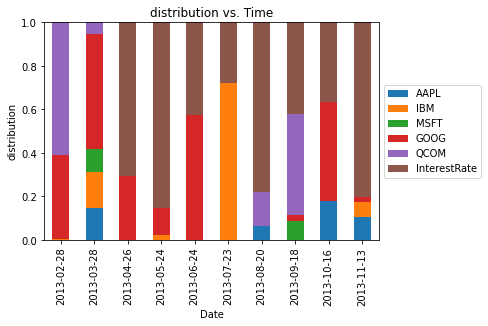

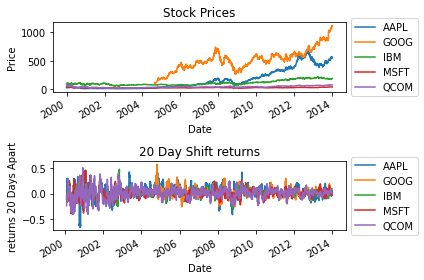

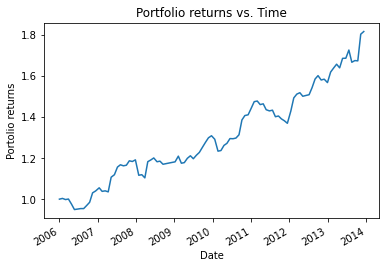

In [63]:

# Remove dates that there are no trades from returns
returns = returns[np.isfinite(returns)]


# Plot portfolio allocation of last 10 periods

ax = distribution.T.iloc[-10:].plot(kind='bar',stacked=True)
plt.ylim([0,1])
plt.xlabel('Date')
plt.ylabel('distribution')
plt.title('distribution vs. Time')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('allocation.png')

# Plot stock prices and shifted returns
fig, axes = plt.subplots(nrows=2,ncols=1)
price.plot(ax=axes[0])
shift_returns.plot(ax=axes[1])
axes[0].set_title('Stock Prices')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title(str(shift)+ ' Day Shift returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('returns ' + str(shift) + ' Days Apart')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('stocks.png', pad_inches=1)
fig.tight_layout()

# Plot portfolio returns vs. time
plt.figure()
returns.plot()
plt.xlabel('Date')
plt.ylabel('Portolio returns')
plt.title('Portfolio returns vs. Time')
# plt.savefig('returns.png')

plt.show()
